# **Prediction of Product upgrade of freemium/trial users**

---




#### **Introduction**
>  Every SaaS product companies have freemium/trial-based product offerings to let the user evaluate their product's worthiness provided with limited features. Every company's motive
is to upgrade the trial user to a premium user, however, in reality, a considerable percentage of
product evaluators use the product with limited features till the trial period or forever. Also, users
who leverage the portal effectively during the trial tenure are considered to be the potential
candidates for premium subscribers. So reaching out to the pertinent consumer is a key growth
pillar for the product's revenue which will also help to focus adverts towards certain customer
groups of an audience instead of reaching to all the consumers who use freemium/trial features. Hence the goal is to predict the user is a potential candidate for the Premium upgrade of not based on certain features

#### **Step 1. Hypothesis Testing**
  Below are the understanding of the dataset and the business problem

1. **Last login** - User who logged recently(within 30 days) indicates that the product is still being evaluated using Freemium feature and indicates the user still in the way to explore the features and likely for product upgradation.
2. **No of logins in last 30 days**  - More no of recent logins(within 30 days) of a user indicates that the freemium feature is being explored heavily have potential possibility for Product upgrade
3. **No of apps** - User who leverages the features such as the component apps are the potential candidate for the Product upgrade
4. **Invited projects** -  User can be invited by other existing product user's projects exemplifies the need of Project collaboration which paves an  opportunity for  Product upgrade    
5. **Is free project created?** - Some users may enrol/Signup but would have not utilized any of freemium related benefits, users who utilized the free project creation features have possibility to opt for the Product upgrade
6. **Storage used** - Users who use product will generate more models and files to explore the features which increase the storage size(limited size for the user), which means the users who use the utilized limited storage efficiently will likely proceed for the Product upgrade
7. **No of users invited** - Users who invites more no other users(other existing customer within their organization or other users) will be treated as Project management peoples or Architects or Team leads who are the high candidate for Product upgrade but at the same time, at the same time is no need that all the invited users for the project will accept the invitation to the projects. 
8. **Users count** - Once the user accepts the project invitation they will be added as a member of the project, the more the users in the projects directly propotional to the active peoples who explores/utilize the features which obviously explains the necessity of the product upgrade.
9. **User's activities count** - Every user activities are counted in project-wise, the more no of activites means the more no of project features are being utilized, which means there is a high probability for the product upgrade.


#### **Step2. Data Exploration**


1. **User Id**- Unique Id of each User
2. **Last login** - Track of the user's last successful login timestamp.  
3. **No of logins** in last 30 days  - No of times a User logged in last 30 days.
4. **Invited projects** - No of projects that a user got invited to join.
5. **Is free project created?** - Boolean flag to track whether the user has started the freemium features or not.
6. **Storage used** - User's utilized storage size.    
7. **No of users invited** - Count of User's project invitation requests to other existing product users.
8. **Users count** - No of users of the project.
9. **User's activities count** - Count of user's activities in the project.
10. **Result** - Boolean target variable specifies whether user will opt for Premium feature or not.       




### **Step3. Exploratory Data Analysis (EDA)**

##### **Loading core libraries**

In [1]:
import sys
!{sys.executable} -m pip install sagemaker pandas numpy --upgrade
import warnings
warnings.filterwarnings('ignore')
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()
prefix = "predictionofpremiumtofreemium"

# Define IAM role
import boto3
import botocore
import re
from sagemaker import get_execution_role

role = get_execution_role()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

import seaborn as sns



     |████████████████████████████████| 517 kB 25.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.80.0-py2.py3-none-any.whl size=716377 sha256=f2e116c579ac4e317282022f0f70d1abee6dd3828de8ba3a8b7085e2e1e66296
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2b/f4/9b/7cb263b4827b149327caa68278e91de6243431d7b1e64e225b
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.77.1
    Uninstalling sagemaker-2.77.1:
      Successfully uninstalled sagemaker-2.77.1


##### **Loading the dataset from S3**

In [2]:
%matplotlib inline
bucket_name = 'predictionofpremiumtofreemium'

s3 = boto3.resource('s3')
# Download the test and train files from S3
data_dir = './data'
output_dir = './output'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
try:
    s3.Bucket(bucket_name).download_file('data/raw/test_dataset.csv','./data/test_raw_dataset.csv')
    s3.Bucket(bucket_name).download_file('data/raw/training_dataset.csv','./data/training_raw_dataset.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise
        
train_data=pd.read_csv('./data/training_raw_dataset.csv')
test_data=pd.read_csv('./data/test_raw_dataset.csv')
train=train_data.copy()
test=test_data.copy()

##### **Data Shape**

In [3]:
print('Train data Shape', train_data.shape)
print('Test data Shape', test_data.shape)

Train data Shape (109227, 11)
Test data Shape (9999, 10)


The training data set has 11 variables (see above) and Test has 10 (excluding dependent feature).

combine both train and test data sets into one, perform Feature Engineering and then divide them later again. This saves the trouble of performing the same steps twice on test and train

##### **Glimpse of dataset**

In [4]:
train['source']='train'
test['source']='test'
data=pd.concat([train,test],ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119226 entries, 0 to 119225
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   User Id                       119226 non-null  object
 1   Last login                    119226 non-null  object
 2   No of logins in last 30 days  119226 non-null  int64 
 3   No of apps                    119226 non-null  int64 
 4   Invited projects              119226 non-null  int64 
 5   Is free project created?      119226 non-null  object
 6   Storage used                  119226 non-null  int64 
 7   No of users invited           119226 non-null  int64 
 8   Users count                   119226 non-null  int64 
 9   User's activities count       119226 non-null  int64 
 10  Result                        109227 non-null  object
 11  source                        119226 non-null  object
dtypes: int64(7), object(5)
memory usage: 10.9+ MB


In [5]:
data = data.drop_duplicates()
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 119226 entries, 0 to 119225
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   User Id                       119226 non-null  object
 1   Last login                    119226 non-null  object
 2   No of logins in last 30 days  119226 non-null  int64 
 3   No of apps                    119226 non-null  int64 
 4   Invited projects              119226 non-null  int64 
 5   Is free project created?      119226 non-null  object
 6   Storage used                  119226 non-null  int64 
 7   No of users invited           119226 non-null  int64 
 8   Users count                   119226 non-null  int64 
 9   User's activities count       119226 non-null  int64 
 10  Result                        109227 non-null  object
 11  source                        119226 non-null  object
dtypes: int64(7), object(5)
memory usage: 11.8+ MB


As per the above data, it is evident that the prepared dataset doesn't have any duplicate values

In [6]:
data.describe()

,No of logins in last 30 days,No of apps,Invited projects,Storage used,No of users invited,Users count,User's activities count
count,119226.000000,119226.000000,119226.000000,119226.000000,119226.000000,119226.000000,119226.000000
mean,0.803013,4.985028,15.026051,1498.427080,1.501711,2.099047,299.552707
std,3.194564,3.163994,8.941732,1658.313691,1.806909,2.165955,331.897817
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,15.000000,827.500000,0.000000,1.000000,165.000000
75%,0.000000,8.000000,23.000000,2912.000000,3.000000,4.000000,582.000000
max,30.000000,10.000000,30.000000,5000.000000,5.000000,6.000000,1000.000000


##### **Missing Values**

In [7]:
data.isnull().sum()

User Id                            0
Last login                         0
No of logins in last 30 days       0
No of apps                         0
Invited projects                   0
Is free project created?           0
Storage used                       0
No of users invited                0
Users count                        0
User's activities count            0
Result                          9999
source                             0
dtype: int64

We don't have any missing values in the dataset except for the Target variable (Response) that’s because we have combined our dataset and these missing values belong to the test dataset., hence the extra efforts related to filling up the missing values and droping the features based on missing values will not be there

##### **Categorical Variables**

In [8]:
# for feature in categorical_features:
categorical_features=[feature for feature in data.columns if data[feature].dtypes=='O' and not feature in ['source','User Id']]
print('Categorical features',categorical_features)


Categorical features ['Last login', 'Is free project created?', 'Result']


Creating new Categorical value based on last login data where the date difference between the last login and the current data will be taken into an account to check whether the user has logged into the system recently or not

##### **Cardinality of Categorical Variables**

In [9]:
for feature in categorical_features:
    print('feature: {}, Unique values: {} '.format(feature, len(data[feature].unique())))
print('feature: {}, Unique values: {} '.format('User Id', len(data['User Id'].unique())))

feature: Last login, Unique values: 106600 
feature: Is free project created?, Unique values: 2 
feature: Result, Unique values: 3 
feature: User Id, Unique values: 119226 


(array([0, 1]), [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

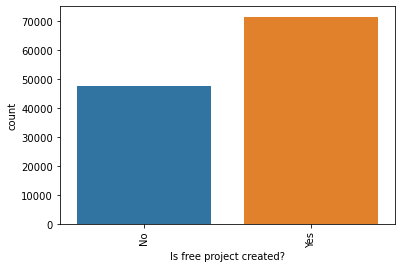

In [10]:
sns.countplot(x='Is free project created?', data=data)
plt.xticks(rotation=90)

##### **Numerical features**

In [11]:
numerical_features = [feature for feature in data.columns if data[feature].dtypes != 'O']

print('Numerical Features:', numerical_features)
print('Number of numerical variables: ', len(numerical_features))
data[numerical_features].head()


Numerical Features: ['No of logins in last 30 days', 'No of apps', 'Invited projects', 'Storage used', 'No of users invited', 'Users count', "User's activities count"]
Number of numerical variables:  7


,No of logins in last 30 days,No of apps,Invited projects,Storage used,No of users invited,Users count,User's activities count
0,0,2,7,0,0,0,0
1,0,2,17,0,0,0,0
2,1,2,7,0,0,0,0
3,0,8,16,2080,3,2,230
4,6,7,6,2062,4,3,506


##### **Numerical variable's distribution analysis using histogram**

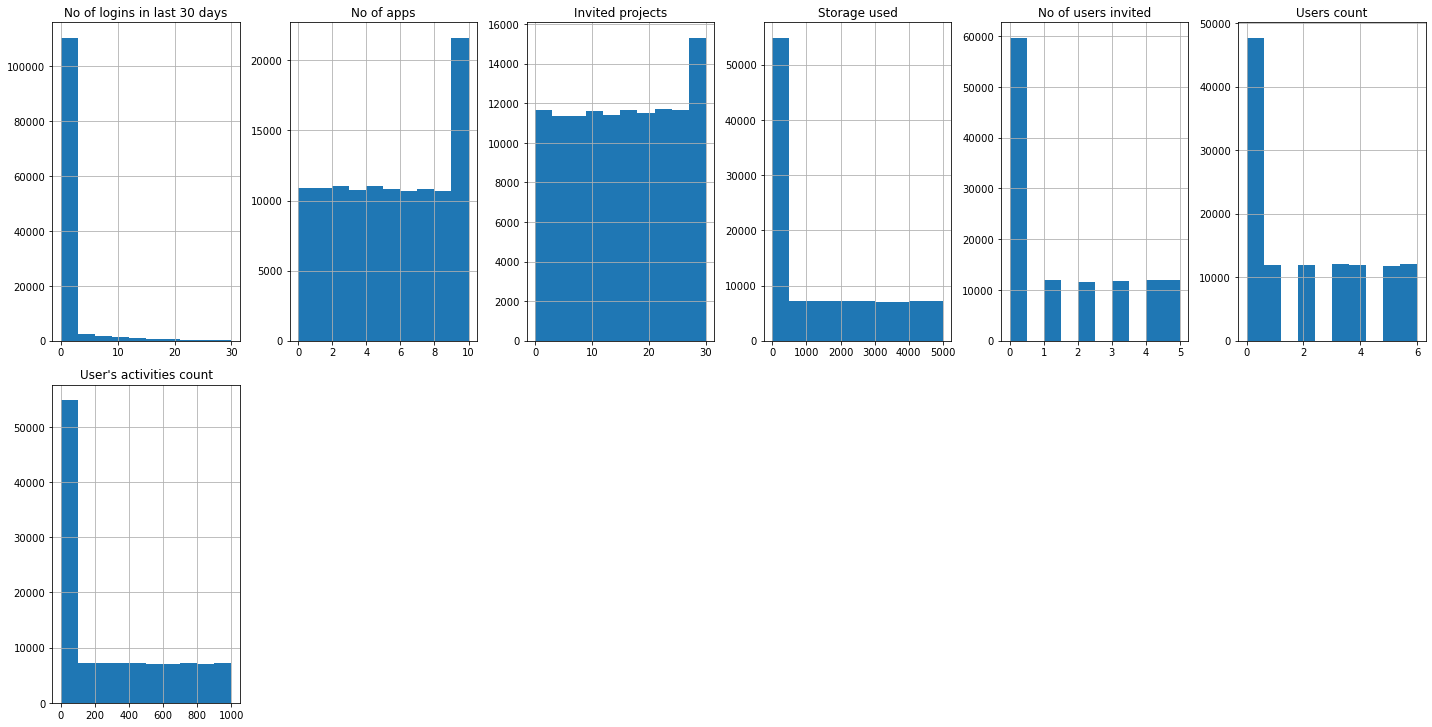

In [12]:
data.hist(figsize=(20,15),layout=(3,6))
plt.tight_layout()
plt.show()

###### **Discrete Numerical Variables**

In [13]:
discrete_feature=[feature for feature in numerical_features if len(data[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_feature)))
print("Discrete Variables ", discrete_feature)
data[discrete_feature].head()

Discrete Variables Count: 3
Discrete Variables  ['No of apps', 'No of users invited', 'Users count']


,No of apps,No of users invited,Users count
0,2,0,0
1,2,0,0
2,2,0,0
3,8,3,2
4,7,4,3


###### **Continous Numerical variable**

In [14]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature + ['User Id']]
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Continuous features {}".format(continuous_feature))


Continuous feature Count 4
Continuous features ['No of logins in last 30 days', 'Invited projects', 'Storage used', "User's activities count"]


Numerical features holds zero values which is valid based on business requirement, hence applying the logarithmic transformation is not a pertinent approach

##### **Numerical variable's Outliers analysis using boxplot**

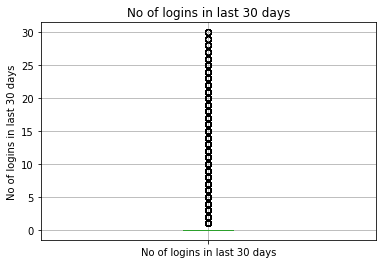

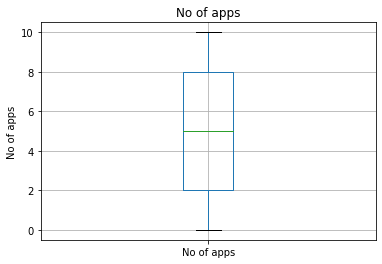

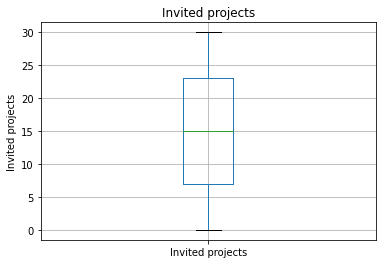

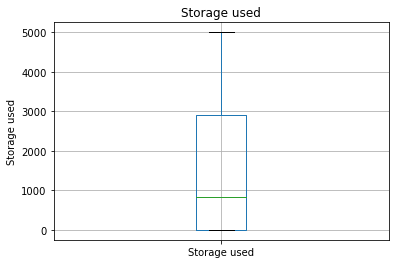

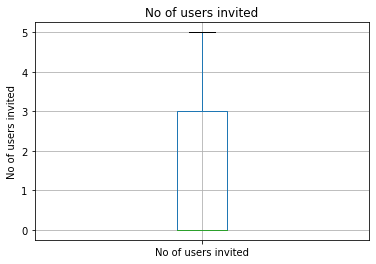

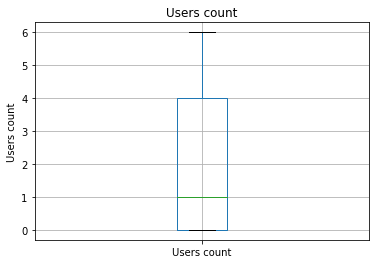

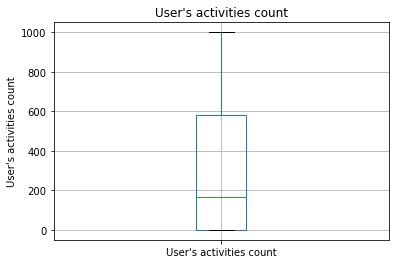

In [15]:
for feature in numerical_features:
    data_clone=data.copy()
    data_clone.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

##### **Transforming the Categorical features into numerical form**

We have to create new feature from the **'last login'**, by applying date difference between 'last login' feature with present date, we have threshold of 30 days to consider whether the login is recent or not. If the date difference is less than 30 then that will be considered as recent login otherwise not

In [16]:
from datetime import datetime
last_login = list(data['Last login'])
for i in range(len(last_login)):
    last_login_date = datetime.strptime(last_login[i], "%m/%d/%Y %H:%M %p")
    end_date = datetime.now()
    last_login_date_diff = abs((end_date-last_login_date).days)
    if last_login_date_diff < 180:
        last_login[i] = 'Yes'
    else:
        last_login[i] = 'No'
data['Recent login'] = list(last_login)

data['Result'].replace({'Yes': 1, 'No': 0}, inplace=True)
data['Is free project created?'].replace({'Yes': 1, 'No': 0}, inplace=True)
data['Recent login'].replace({'Yes': 1, 'No': 0}, inplace=True)
data.head()



,User Id,Last login,No of logins in last 30 days,No of apps,Invited projects,Is free project created?,Storage used,No of users invited,Users count,User's activities count,Result,source,Recent login
0,9c617e13-1e58-499a-bdba-caed007a4a4c,04/09/2021 1:53 AM,0,2,7,0,0,0,0,0,0.0,train,0
1,95ba3c4b-f049-4ce5-9e32-4a9a1513aa05,02/05/2021 2:25 AM,0,2,17,0,0,0,0,0,0.0,train,0
2,ea593eac-2092-4104-8aa3-d480c9a8d592,10/03/2021 9:15 AM,1,2,7,0,0,0,0,0,0.0,train,1
3,51dfc110-de98-4bc2-b5a1-4936cf00d0cb,01/04/2021 11:26 PM,0,8,16,1,2080,3,2,230,0.0,train,0
4,ce3a78a6-db1c-43a2-afe0-71d751cc25fd,10/26/2021 2:59 AM,6,7,6,1,2062,4,3,506,1.0,train,1


### **Step5. Data Cleaning**

*   Dropping the 'User Id' feature where each value is unique. 
*   Dropping the 'Last login' feature as the new feature 'Recent login' is created based on it which will be used going forward for the data analysis

In [17]:
data.drop('User Id',axis=1,inplace=True)
data.drop('Last login',axis=1,inplace=True)
data.head()

,No of logins in last 30 days,No of apps,Invited projects,Is free project created?,Storage used,No of users invited,Users count,User's activities count,Result,source,Recent login
0,0,2,7,0,0,0,0,0,0.0,train,0
1,0,2,17,0,0,0,0,0,0.0,train,0
2,1,2,7,0,0,0,0,0,0.0,train,1
3,0,8,16,1,2080,3,2,230,0.0,train,0
4,6,7,6,1,2062,4,3,506,1.0,train,1


### **Step6: Feature Selection**

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
numerical_features = numerical_features+['Recent login']
scaler.fit(data[numerical_features])
scaler.transform(data[numerical_features])
data_final = pd.concat([data[['Result']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(data[numerical_features]), columns=numerical_features)],
                    axis=1)
data_final['Recent login'] = data_final['Recent login'].astype('Int64')
data_final.to_csv('./data/X_train.csv',index=False)
data_final.shape

(119226, 9)

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data_final['Result'] = data_final['Result'].astype('Int64')
X = data_final.iloc[:,1:9]  #independent columns
y = data_final['Result'].fillna(0)  #target column i.e Result
y=y.astype('int')

In [20]:
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
fit.scores_

array([7.12517853e+01, 4.78438827e-01, 4.92366934e-02, 1.81123506e+04,
       1.74391949e+04, 2.22168216e+04, 1.93579164e+04, 7.21665446e+02])

In [21]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores

,Specs,Score
0,No of logins in last 30 days,71.251785
1,No of apps,0.478439
2,Invited projects,0.049237
3,Storage used,18112.350586
4,No of users invited,17439.194915
5,Users count,22216.821561
6,User's activities count,19357.916430
7,Recent login,721.665446


In [22]:
print(featureScores.nlargest(10,'Score')) 

                          Specs         Score
5                   Users count  22216.821561
6       User's activities count  19357.916430
3                  Storage used  18112.350586
4           No of users invited  17439.194915
7                  Recent login    721.665446
0  No of logins in last 30 days     71.251785
1                    No of apps      0.478439
2              Invited projects      0.049237


[0.03704577 0.02577098 0.04122475 0.21674633 0.1444829  0.26069546
 0.26629829 0.00773552]


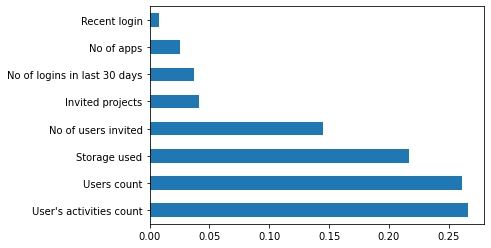

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

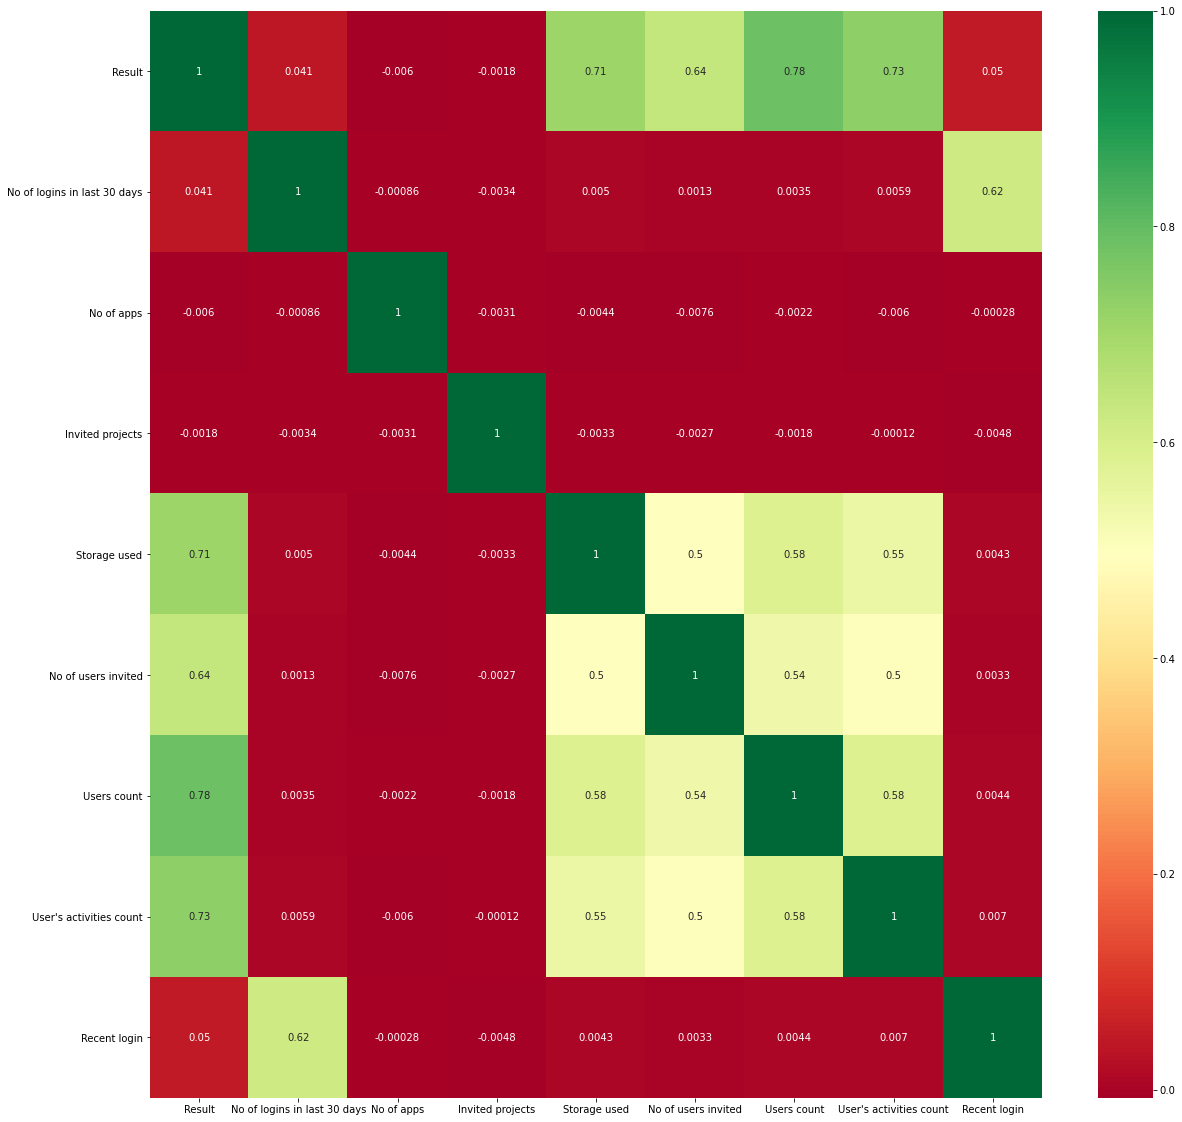

In [24]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data_final.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [25]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0))
feature_sel_model.fit(X, y)
# selected_feature = X.columns[(feature_sel_model.get_support())]
total_features = [feature for feature in X.columns]
selected_features = [feature for feature in X.columns[(feature_sel_model.get_support())]]
unselected_features = [feature for feature in X.columns if feature not in selected_features]
print('total features: {}'.format(total_features))
print('selected features: {}'.format(selected_features))
print('unselected features: {}'.format(unselected_features))


total features: ['No of logins in last 30 days', 'No of apps', 'Invited projects', 'Storage used', 'No of users invited', 'Users count', "User's activities count", 'Recent login']
selected features: ['Storage used', 'No of users invited', 'Users count', "User's activities count", 'Recent login']
unselected features: ['No of logins in last 30 days', 'No of apps', 'Invited projects']


Hence, the selected features for the model building -> **'Storage used', 'No of users invited', 'Users count', "User's activities count"**

In [26]:
data_final.head()

,Result,No of logins in last 30 days,No of apps,Invited projects,Storage used,No of users invited,Users count,User's activities count,Recent login
0,0,0.000000,0.2,0.233333,0.0000,0.0,0.000000,0.000,0
1,0,0.000000,0.2,0.566667,0.0000,0.0,0.000000,0.000,0
2,0,0.033333,0.2,0.233333,0.0000,0.0,0.000000,0.000,1
3,0,0.000000,0.8,0.533333,0.4160,0.6,0.333333,0.230,0
4,1,0.200000,0.7,0.200000,0.4124,0.8,0.500000,0.506,1


In [27]:
train=data.loc[data['source']=='train']
test=data.loc[data['source']=='test']
train.drop(['No of logins in last 30 days', 'No of apps', 'Invited projects', 'Recent login', 'Is free project created?', 'source'],axis=1,inplace=True)
test.drop(['No of logins in last 30 days', 'No of apps', 'Invited projects', 'Recent login', 'Is free project created?', 'source','Result'],axis=1,inplace=True)
train.shape,test.shape

((109227, 5), (9999, 4))

In [28]:
X=train.drop(['Result'],axis=1)
y=train['Result'].astype('int')

!{sys.executable}  -m pip install imbalanced-learn
# test.drop(['Response'],axis=1,inplace=True) ## For Final Prediction
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.30 ,random_state = 5)
lr=LogisticRegression(solver="liblinear", random_state=0)

lr.fit(x_train,y_train)

     |████████████████████████████████| 199 kB 25.3 MB/s            
     |████████████████████████████████| 189 kB 63.5 MB/s            


LogisticRegression(random_state=0, solver='liblinear')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.991


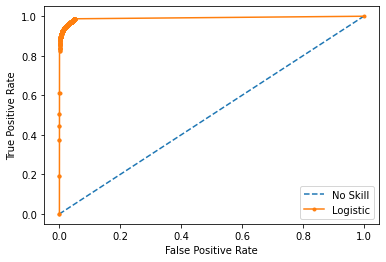

In [29]:
## Before Balancing

ns_probs = [0 for _ in range(len(y_test))]

lr_probs = lr.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot

plt.show()

We can see that with using simplest Classification Algorithm we are able to get ROC-AUC score as 0.991

##### Handling an Unbalanced Dataset

In [30]:

smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)
X_train_balanced,X_test_balanced,y_train_balanced,y_test_balanced=train_test_split(X_balanced,y_balanced,test_size=0.3,random_state=5)

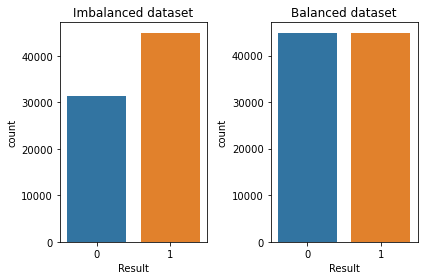

In [31]:
plt.subplot(121)
sns.countplot(y_train)
plt.title('Imbalanced dataset')

plt.subplot(122)
sns.countplot(y_train_balanced)
plt.title('Balanced dataset')

plt.savefig('./output/balanced_vs_unbalanced_dataset.png')
plt.tight_layout()
plt.show()

In [32]:

lr_balanced=LogisticRegression(solver="liblinear", random_state=0)
lr_balanced.fit(X_train_balanced,y_train_balanced)

LogisticRegression(random_state=0, solver='liblinear')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.992


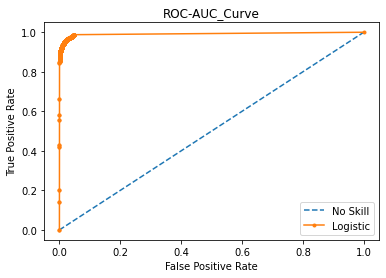

In [33]:
## After Balancing
ns_probs = [0 for _ in range(len(y_test_balanced))]


lr_probs = lr_balanced.predict_proba(X_test_balanced)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test_balanced, ns_probs)
lr_auc = roc_auc_score(y_test_balanced, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_balanced, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_balanced, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot

plt.title('ROC-AUC_Curve')

plt.show()

We can clearly see that after Balancing the ratio of target variable . Our ROC-AUC score has increased to from 0.991 to 0.992.

Testing across various models., We will be using Cross-Validation to find the model which has the best accuracy.

In [34]:
models=[]
models.append(('LogisticRegression',LogisticRegression(solver="liblinear", random_state=5)))
models.append(('DecisionTree',DecisionTreeClassifier(random_state=5)))
models.append(('RandomForest',RandomForestClassifier(random_state=5)))
models.append(('knn',KNeighborsClassifier()))

In [35]:
results=[]
names=[]
for name,model in models:   
    kf=KFold(n_splits=5,shuffle=True,random_state=5)
    cv_score=cross_val_score(model,X_balanced,y_balanced,cv=kf,scoring='roc_auc',verbose=1)
    results.append(cv_score)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_score.mean(), cv_score.std())
    print(msg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression: 0.991211 (0.000275)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTree: 0.992644 (0.000213)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForest: 0.993263 (0.000192)
knn: 0.989778 (0.000455)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.8s finished


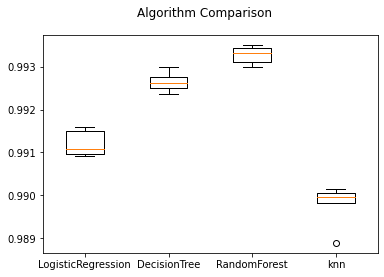

In [36]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('./output/model_comparison.png')
plt.show()

##### **ROC-AUC curve for all the models**

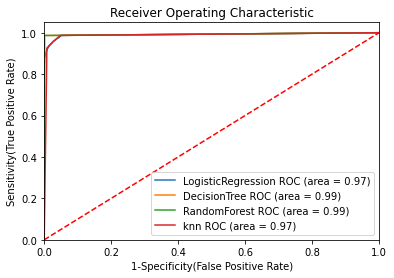

In [37]:
for name,model in models:
#     model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc =roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

We can see that RandomForest has performed the best so we will go with it.

In [38]:
rtree=RandomForestClassifier(random_state=5)
rtree.fit(X_train_balanced,y_train_balanced)
y_pred=rtree.predict(X_test_balanced)
print('ROC-AUC score for Random Forest: ',roc_auc_score(y_test_balanced,y_pred))


ROC-AUC score for Random Forest:  0.9929575256307102


No Skill: ROC AUC=0.500
Test Score: ROC AUC=0.993
Train Score: ROC AUC=0.994


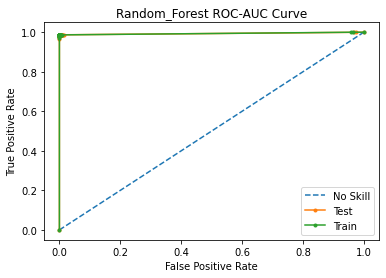

In [39]:
ns_probs = [0 for _ in range(len(y_test_balanced))]

## Tst
lr_probs_test = rtree.predict_proba(X_test_balanced)
# keep probabilities for the positive outcome only
lr_probs_test = lr_probs_test[:, 1]

## Train
lr_probs_train = rtree.predict_proba(X_train_balanced)
# keep probabilities for the positive outcome only
lr_probs_train = lr_probs_train[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test_balanced, ns_probs)
lr_auc_test = roc_auc_score(y_test_balanced, lr_probs_test)
lr_auc_train = roc_auc_score(y_train_balanced, lr_probs_train)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Test Score: ROC AUC=%.3f' % (lr_auc_test))
print('Train Score: ROC AUC=%.3f' % (lr_auc_train))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_balanced, ns_probs)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test_balanced, lr_probs_test)
lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train_balanced, lr_probs_train)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr_test, lr_tpr_test, marker='.', label='Test')
plt.plot(lr_fpr_train, lr_tpr_train, marker='.', label='Train')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title('Random_Forest ROC-AUC Curve')
plt.savefig('./output/Random_Forest ROC-AUC Curve.png')
plt.show()

Ensembled methods to increase our accuracy.

In [40]:
!{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=5,max_depth=5)
xgb.fit(X_train_balanced,y_train_balanced)
y_pred=xgb.predict(X_test_balanced)

     |████████████████████████████████| 173.6 MB 2.3 kB/s             
[07:02:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


No Skill: ROC AUC=0.500
Test Score: ROC AUC=0.994
Train Score: ROC AUC=0.994


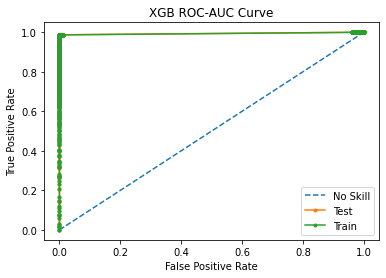

In [41]:
ns_probs = [0 for _ in range(len(y_test_balanced))]

## Tst
lr_probs_test = xgb.predict_proba(X_test_balanced)
# keep probabilities for the positive outcome only
lr_probs_test = lr_probs_test[:, 1]

## Train
lr_probs_train = xgb.predict_proba(X_train_balanced)
# keep probabilities for the positive outcome only
lr_probs_train = lr_probs_train[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test_balanced, ns_probs)
lr_auc_test = roc_auc_score(y_test_balanced, lr_probs_test)
lr_auc_train = roc_auc_score(y_train_balanced, lr_probs_train)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Test Score: ROC AUC=%.3f' % (lr_auc_test))
print('Train Score: ROC AUC=%.3f' % (lr_auc_train))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_balanced, ns_probs)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test_balanced, lr_probs_test)
lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train_balanced, lr_probs_train)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr_test, lr_tpr_test, marker='.', label='Test')
plt.plot(lr_fpr_train, lr_tpr_train, marker='.', label='Train')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title('XGB ROC-AUC Curve')
plt.savefig('./output/xgb_ROC-AUC Curve.png')
plt.show()

XGB Classifier for final predictions.

In [42]:
predsTest = xgb.predict(test)
submission = pd.DataFrame({  "id": test_data['User Id'], "Result":predsTest })
submission.to_csv('./output/XGB_submission.csv', index=False)
submission.head()

,id,Result
0,f0527f66-9e71-4364-b550-840b9955dcc7,1
1,0421417f-62a1-45c6-8db9-f4bcc7e01377,1
2,b358515e-01c8-4744-884d-4fbbddae7bce,1
3,b0d4aec2-da74-4c7b-83a8-4e0655329960,0
4,84a4a8b8-a93f-43aa-88e9-48844e8f9979,0


##### As we have selected the XGB Classifier for final predictions, we will upload the processed trained and test data to S3 to build model using a built-in XGBoost open source algorithm provided by sagemaker

In [43]:
x_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([y_test_balanced, X_test_balanced], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([y_train_balanced, X_train_balanced], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)


When we construct a training job using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. Also, when we perform a batch transform job while testing our model, SageMaker expects the input data to be stored on S3. We will be using the SageMaker API to do this.
Notice while creating our train and validation data the labels are concatenated as the first column. We do this so because, for the train & validation data, it is assumed that the first entry in each row is the target variable.
Now we will be uploading our data to S3 using sagemaker’s upload_data method. The data will be uploaded in the default S3 bucket associated with the current Sagemaker session.

In [44]:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)


##### **Training the Model**

In [45]:
container = get_image_uri(boto3.Session().region_name, 'xgboost',  repo_version='1.0-1')
xgb = sagemaker.estimator.Estimator(container, role, train_instance_count=1, train_instance_type='ml.m4.xlarge', output_path='s3://{}/{}/output'.format(bucket_name, 'model'), sagemaker_session=session)
from sagemaker.predictor import csv_serializer
s3_input_train = sagemaker.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data=val_location, content_type='csv')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


we will call the fit method on our estimator object and pass on the location of training and validation data in S3. We also need to make sure that Sagemaker knows that our data is in CSV format.

In [46]:
xgb.set_hyperparameters(
            max_depth=5,
            eta=0.2,
            gamma=4,
            min_child_weight=6,
            subsample=0.8,
            silent=0,
            objective="binary:logistic",
            num_round=100,
        )

xgb.fit({'train': s3_input_train, 'validation':s3_input_validation})

2022-03-20 15:30:46 Starting - Starting the training job...
2022-03-20 15:31:12 Starting - Preparing the instances for trainingProfilerReport-1647790246: InProgress
.........
2022-03-20 15:32:32 Downloading - Downloading input data...
2022-03-20 15:33:10 Training - Downloading the training image......
2022-03-20 15:34:10 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[15:34:14] 89696x4 matrix with 358784 entries loaded from /opt/ml/input/data/train?format=

##### **Testing The Model**

In [47]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line', wait=True, logs=False)

.................................................................!


In [50]:
!aws s3 cp --recursive $xgb_transformer.output_path $output_dir

download: s3://sagemaker-ap-southeast-1-805451413154/sagemaker-xgboost-2022-03-20-15-34-59-006/test.csv.out to output/test.csv.out


##### **Deploying the Model**

In [51]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

------!

The predictions stored in Y_pred are currently stored as a comma-delimited string and so we would like to break it up as a NumPy array. Now on evaluating the output, the metric score should be the same as the one we obtained during the Batch Transform job.

In [52]:
from sklearn.metrics import mean_squared_error as mse
Y_pred = pd.read_csv(os.path.join(output_dir, 'test.csv.out'), header=None)
# Y_pred = pd.read_csv('./data/test.csv.out', header=None)
error = np.sqrt(mse(Y_pred,y_test))
print('mse {}'.format(error))

mse 0.08848066407120254


Accessing the endpoint attribute of our predictor object provides us with our **model’s endpoint**, that we can further use to interact with our model

In [53]:
str(xgb_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'sagemaker-xgboost-2022-03-20-15-43-48-942'

##### **validating the data using deployed model's endpoint**

In [54]:
!head -10 ./data/validation.csv > ./data/test_predict.csv

In [60]:
from sagemaker.predictor import json_serializer, json_deserializer, Predictor, csv_serializer, Predictor, RealTimePredictor


# predictor = RealTimePredictor(endpoint_name=str(xgb_predictor.endpoint), content_type = 'text/csv')
predictor = Predictor(endpoint_name=str(xgb_predictor.endpoint), sagemaker_session=sagemaker.Session(), serializer=csv_serializer,
                                content_type='text/csv', accept='application/json')

with open('./data/test_predict.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        inference_response = predictor.predict(data=payload[2:])
        response = float(str(inference_response.decode("utf-8") )) * 100
        if  response > 80: 
            result = "Yes"
            possibility = "High"
            message = "Input user is a potential candidate for Premium upgrade"
        else:
            result = "No"
            possibility = "Very Low"
            message = "Input user is not a potential candidate for Premium upgrade"
        response = {
            "result": result,
            "possibility": possibility,
            "message": message
        } 
        print('Request_payload: {} , product_upgrade_possibility: {} '.format(payload[2:], response))

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
accept is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=

Request_payload: 0,0,0,0 , product_upgrade_possibility: {'result': 'No', 'possibility': 'Very high', 'message': 'Input user is not a potential candidate for Premium upgrade'} 
Request_payload: 934,4,5,523 , product_upgrade_possibility: {'result': 'Yes', 'possibility': 'Very high', 'message': 'Input user is a potential candidate for Premium upgrade'} 
Request_payload: 2389,3,5,86 , product_upgrade_possibility: {'result': 'Yes', 'possibility': 'Very high', 'message': 'Input user is a potential candidate for Premium upgrade'} 
Request_payload: 0,0,0,0 , product_upgrade_possibility: {'result': 'No', 'possibility': 'Very high', 'message': 'Input user is not a potential candidate for Premium upgrade'} 
Request_payload: 4593,4,1,137 , product_upgrade_possibility: {'result': 'Yes', 'possibility': 'Very high', 'message': 'Input user is a potential candidate for Premium upgrade'} 
Request_payload: 0,0,0,0 , product_upgrade_possibility: {'result': 'No', 'possibility': 'Very high', 'message': 'Inp